In [1]:
# imports
import sys
import pandas as pd
sys.path.append('../../') # to access the files in higher directories
sys.path.append('../') # to access the files in higher directories
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import core_exp as cx
import core_calib as cal

In [2]:
params = cx.params_all.copy()
params["hyper_opt"] = False
exp_key = "n_estimators"
exp_values = [1,2,3,4,5,6,7,8,9,10,20,50,100,200]

In [3]:
calib_results_dict, data_list = cx.run_exp(exp_key, exp_values, params)
tables = cal.mean_and_ranking_table(calib_results_dict, 
                                    params["metrics"], 
                                    params["calib_methods"], 
                                    data_list, 
                                    mean_and_rank=False, 
                                    std=True)

In [4]:
plot_calib_methods = params["calib_methods"].copy()
# plot_calib_methods.remove("Rank")
# plot_calib_methods.remove("Elkan")
# plot_calib_methods.remove("RF")
plot_calib_methods

['RF', 'CRF', 'RF_ens']

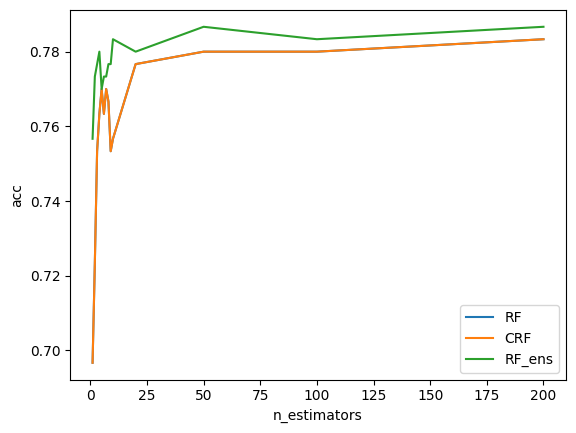

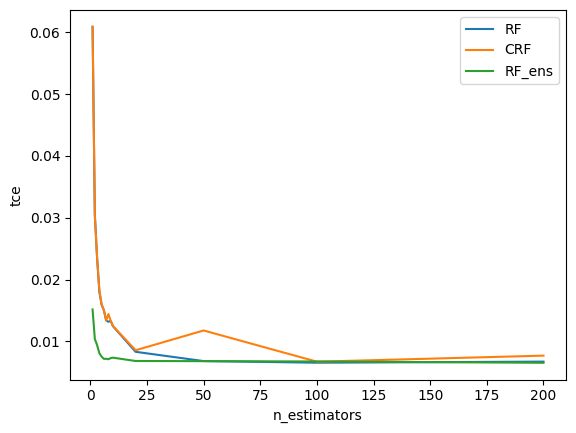

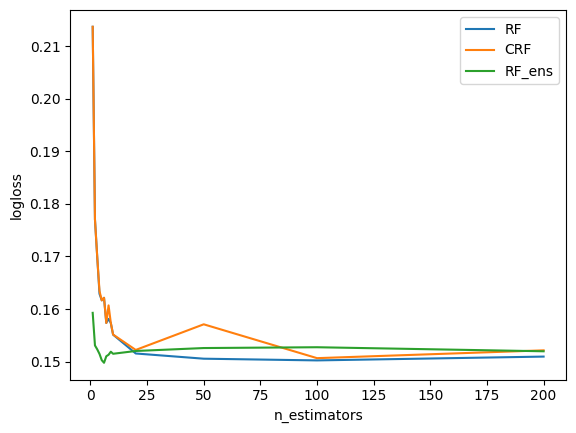

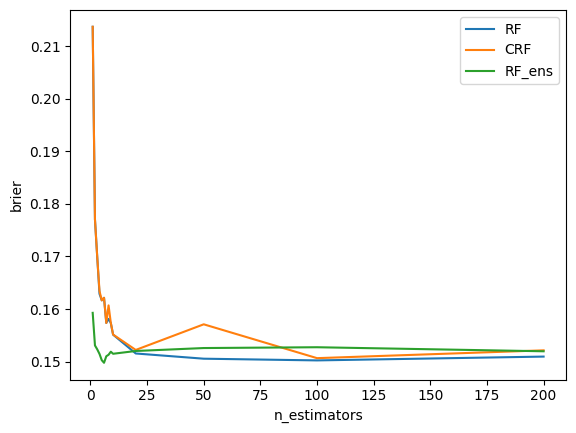

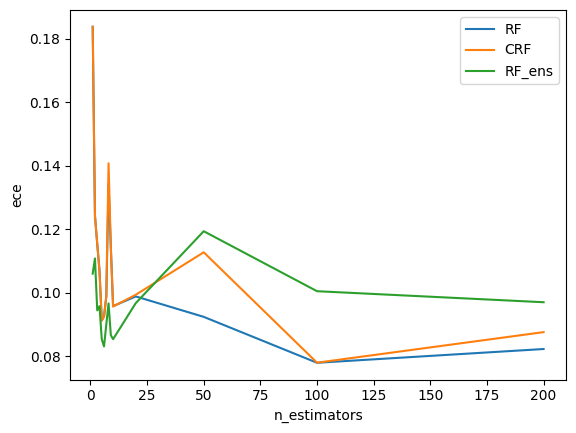

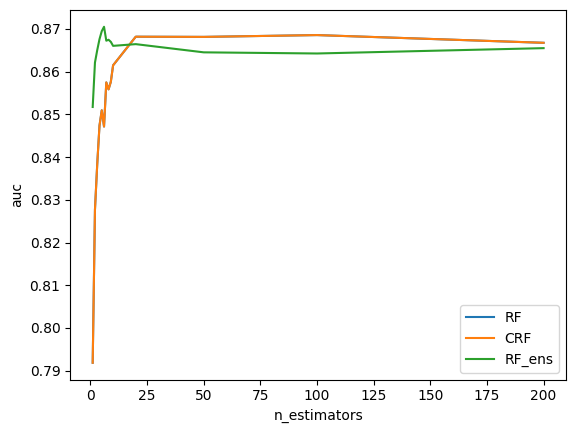

In [5]:
for metric in params["metrics"]:
    ax = tables[metric][plot_calib_methods].plot()
    ax.set_xlabel(exp_key)
    ax.set_ylabel(metric)